# EDA — Face dataset (train / test folders per emotion)

This notebook performs exploratory data analysis on the `data/face` dataset. It expects the following layout relative to the repository root:
```
The notebook will: count images per class, plot class distributions, show sample images per class, check image sizes and modes (RGB vs grayscale).

In [1]:
# Standard imports for EDA
import os
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import pandas as pd

sns.set(style="whitegrid")

In [3]:
# Dataset root (relative to this notebook). If you run the notebook from project root, this will work.
DATA_DIR = Path('..') / 'data' / 'face'
print('Looking for data at:', DATA_DIR.resolve())
assert DATA_DIR.exists(), f'Data directory not found: {DATA_DIR.resolve()}'

Looking for data at: /Users/owner/Documents/news-bias-detection/data/face


In [4]:
# Discover class names from the train folder (sorted)
train_dir = DATA_DIR / 'train'
test_dir = DATA_DIR / 'test'
classes = sorted([p.name for p in train_dir.iterdir() if p.is_dir()])
print('Found classes (train):', classes)

Found classes (train): ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
# Count images per class for train and test
def count_images(root_dir):
    counts = {}
    for cls in sorted([p.name for p in root_dir.iterdir() if p.is_dir()]):
        cls_dir = root_dir / cls
        files = [f for f in cls_dir.rglob('*') if f.is_file()]
        counts[cls] = len(files)
    return counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)
print('Train counts:', train_counts)
print('Test counts:', test_counts)

# Combine into DataFrame for plotting
df_counts = pd.DataFrame({
    'class': list(train_counts.keys()),
    'train': list(train_counts.values()),
    'test': [test_counts.get(c, 0) for c in train_counts.keys()]
})
df_counts['total'] = df_counts['train'] + df_counts['test']
df_counts = df_counts.sort_values('total', ascending=False)
df_counts

Train counts: {'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}
Test counts: {'angry': 958, 'disgust': 111, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}


,class,train,test,total
3,happy,7215,1774,8989
4,neutral,4965,1233,6198
5,sad,4830,1247,6077
2,fear,4097,1024,5121
0,angry,3995,958,4953
6,surprise,3171,831,4002
1,disgust,436,111,547


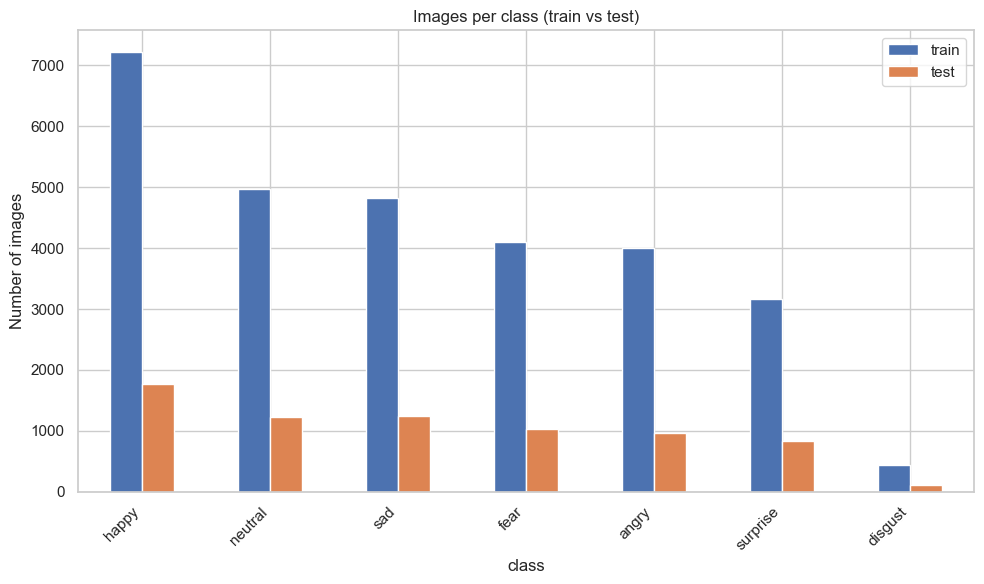

In [6]:
# Plot class distribution (train vs test)
fig, ax = plt.subplots(figsize=(10,6))
df_plot = df_counts.set_index('class')[['train','test']]
df_plot.plot(kind='bar', stacked=False, ax=ax)
ax.set_ylabel('Number of images')
ax.set_title('Images per class (train vs test)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

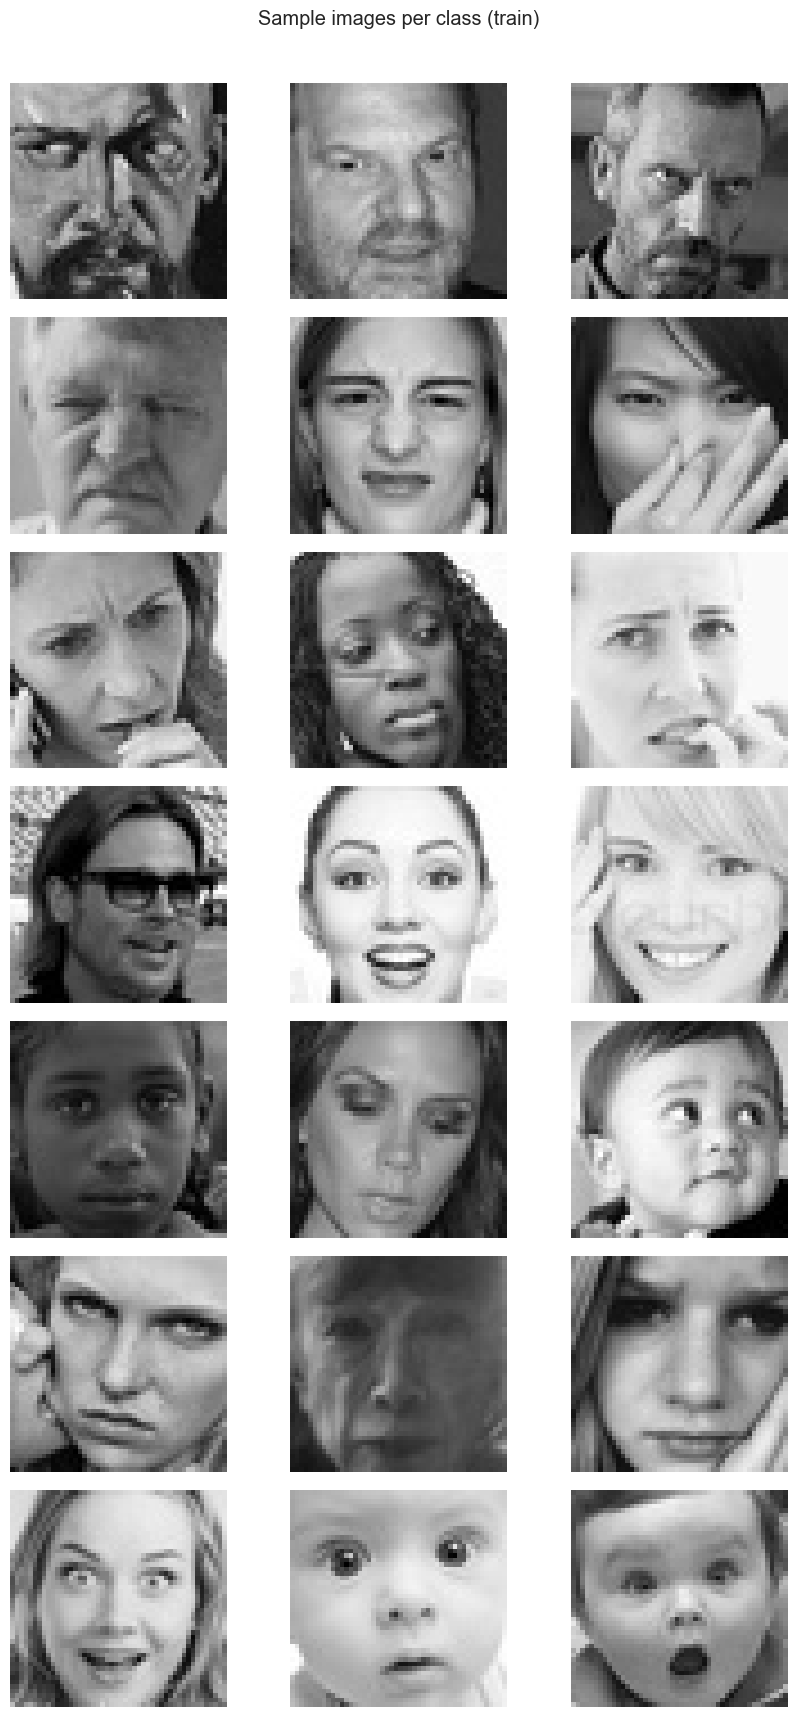

In [8]:
# Helper to sample images from a class directory
import random
def sample_images_for_class(root_dir, cls, n=3):
    cls_dir = root_dir / cls
    all_files = [p for p in cls_dir.glob('*') if p.is_file()]
    if not all_files:
        return []
    return random.sample(all_files, min(n, len(all_files)))

# Show a small grid of samples per class (from train)
n_cols = 3
n_rows = len(classes)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*2.5))
for i, cls in enumerate(classes):
    samples = sample_images_for_class(train_dir, cls, n_cols)
    for j in range(n_cols):
        ax = axes[i, j] if n_rows > 1 else axes[j]
        ax.axis('off')
        if j < len(samples):
            try:
                img = Image.open(samples[j])
                ax.imshow(img.convert('RGB'))
            except Exception as e:
                ax.text(0.5, 0.5, f'Error: {e}', ha='center')
        else:
            ax.text(0.5, 0.5, 'No image', ha='center')
    # label left-most column with class name
    axes[i, 0].set_ylabel(cls, rotation=0, labelpad=40, va='center')
plt.suptitle('Sample images per class (train)')
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()

Total images inspected (train): 28709


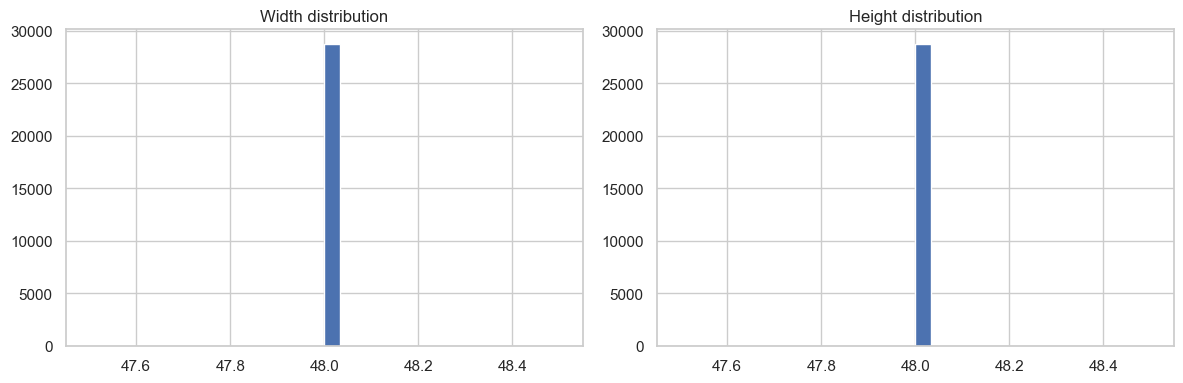

Counter({'L': 28709})

In [9]:
# Gather image size (width, height) and mode statistics across train (can extend to test)
sizes = []
modes = []
for cls in classes:
    for p in (train_dir/cls).glob('*'):
        if not p.is_file():
            continue
        try:
            with Image.open(p) as im:
                sizes.append(im.size)  # (width, height)
                modes.append(im.mode)
        except Exception:
            pass

print('Total images inspected (train):', len(sizes))
sizes_arr = np.array(sizes) if sizes else np.zeros((0,2))

# Plot width and height distributions
if sizes_arr.size:
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    axes[0].hist(sizes_arr[:,0], bins=30)
    axes[0].set_title('Width distribution')
    axes[1].hist(sizes_arr[:,1], bins=30)
    axes[1].set_title('Height distribution')
    plt.tight_layout()
    plt.show()
else:
    print('No sizes to plot')

# Mode counts (RGB/L/LA/etc)
mode_counts = Counter(modes)
mode_counts

In [10]:
# Show a small table of image modes (top)
pd.DataFrame.from_dict(mode_counts, orient='index', columns=['count']).sort_values('count', ascending=False)

,count
L,28709
